In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
import torch, torcwa
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt

from utils.paths import *
from utils import utils
from evaluation.diffraction_measurement import torcwa_simulation
from data.data_config import get_data_cfg
from evaluation.metrics import *

# Load a Clean Sample (X-shaped - Section 3.1)

Meta-atom height (um) 1.228:
Wavelength (um): 0.875


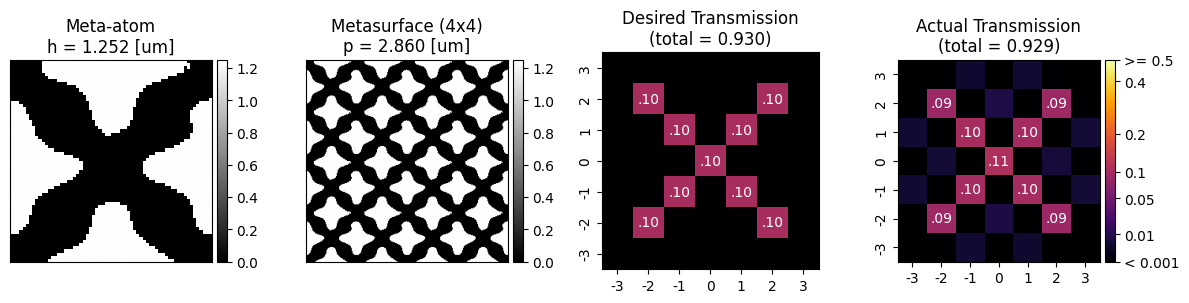

Original relative error: 0.156


In [60]:
# Load the meta-atom
data_cfg = get_data_cfg('b2')

# the sample presented in the paper, section 3.1, figure 4, under 0.875 illumination
sample = torch.load(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'x-shape.pt'), weights_only=False)['2']
idx = 1 

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# layer = utils.binary_projection(sample['sample'][-1][idx][0], beta=1e6).to(device)
layer = sample['sample'][-1, idx, 0].to(device)
h = sample['sample'][-1, idx, 1].mean().to(device) * max(data_cfg.heights)
# lam = sample['lvec'][idx].to(device)
lam = sample['scattering'][idx, -1].to(device)

print(f'Meta-atom height (um) {h.item():.3f}:')
print(f'Wavelength (um): {lam.item():.3f}')

desired_scatterings = utils.reconstruct_scatterings(sample['desired_scatterings'][idx:idx+1], data_cfg)
actual_scatterings = utils.eliminate_unsupported_components(sample['actual_scatterings'][idx:idx+1], data_cfg )
original_actual_scatterings = utils.reconstruct_scatterings(actual_scatterings, data_cfg)

original_relative_error = relative_error(original_actual_scatterings['Tte'], desired_scatterings['Tte'])[0]

phy_kwargs = dict(periodicity=data_cfg.periodicity, h=h, lam=lam, tet=0.0, substrate=data_cfg.substrate, structure=data_cfg.structure)
# utils.show_meta_atom_and_scatterings(meta_atom=h*layer, type='desired-actual', s1=desired_scatterings['Tte'][0].cpu(), s2=original_actual_scatterings['Tte'][0].cpu(), data_cfg=data_cfg)
utils.show_meta_atom_and_scatterings(meta_atom=h*layer, type='desired-actual', s1=desired_scatterings['Tte'][0].cpu(), s2=original_actual_scatterings['Tte'][0].cpu(), data_cfg=data_cfg)
print(f'Original relative error: {original_relative_error:.3f}')


In [61]:
lams = torch.arange(0.825, 0.925, 0.005).to(device)

# Simulate the diffraction efficiencies under different wavelengths
relative_errors = {
    'lam': [],
    'relative_error': [],
    'distance_from_original_relative_error': []
}
for lam in lams:
    phy_kwargs['lam'] = lam
    scatterings = torcwa_simulation(phy_kwargs, layer, rcwa_orders=data_cfg.rcwa_orders)
    actual_relative_error = relative_error(scatterings['Tte'], desired_scatterings['Tte'][0])
    distance_from_original_relative_error = actual_relative_error - original_relative_error
    relative_errors['lam'].append(lam.item())
    relative_errors['relative_error'].append(actual_relative_error.item())
    relative_errors['distance_from_original_relative_error'].append(distance_from_original_relative_error.item())

# Save the results

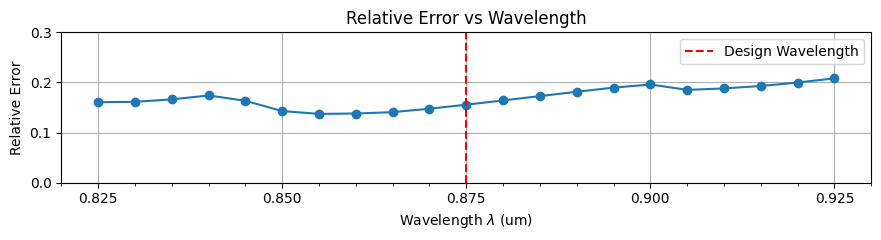

In [64]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(9, 2.5))

# Plot relative error vs lam
import matplotlib.ticker as ticker

major_ticks = [0.825, 0.850, 0.875, 0.900, 0.925]

axs.plot(relative_errors['lam'], relative_errors['relative_error'], marker='o')
axs.axvline(x=0.875, color='red', linestyle='--', label='Design Wavelength')
axs.legend()

axs.set_xlabel('Wavelength $\\lambda$ (um)')
axs.set_ylabel('Relative Error')
axs.set_title('Relative Error vs Wavelength')
axs.grid(True)
axs.set_ylim([0, 0.3])

# Set major and minor ticks for axs[0]
axs.set_xticks(major_ticks)
axs.set_xticklabels([f"{tick:.3f}" for tick in major_ticks])
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))

plt.tight_layout()
plt.savefig(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'wavelength_sensitivity.pdf'), dpi=600)
plt.show()
